## Imports and Functions 

In [6]:
"""
A complete implementation and training of a CIFAR10 classifier.

The prompt is to create another LearningRateScheduler.

"""
from typing import Tuple, List
from torch.optim.lr_scheduler import _LRScheduler

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm
import numpy as np
from model import MiniCNN
from scheduler import CustomLRScheduler
from config import CONFIG
import time
from matplotlib import pyplot as plt
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def get_cifar10_data() -> Tuple[DataLoader, DataLoader]:
    """
    Get the CIFAR10 data from torchvision.

    Arguments:
        None

    Returns:
        train_loader (DataLoader): The training data loader.
        test_loader (DataLoader): The test data loader.

    """
    # Get the training data:
    train_data = CIFAR10(
        root="data/cifar10", train=True, download=True, transform=CONFIG.transforms
    )
    # Create a data loader for the training data:
    train_loader = DataLoader(train_data, batch_size=CONFIG.batch_size, shuffle=True)
    # Get the test data:
    test_data = CIFAR10(
        root="data/cifar10", train=False, download=True, transform=CONFIG.transforms
    )
    # Create a data loader for the test data:
    test_loader = DataLoader(test_data, batch_size=CONFIG.batch_size, shuffle=True)
    # Return the data loaders:
    return train_loader, test_loader


def train(
    model: torch.nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    num_epochs: int,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    learning_rate_scheduler: torch.optim.lr_scheduler._LRScheduler,
    device: torch.device = device,
) -> None:
    """
    Train a model on the data.

    Arguments:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): The training data loader.
        test_loader (DataLoader): The test data loader.
        num_epochs (int): The number of epochs to train for.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        criterion (torch.nn.Module): The loss function to use.
        learning_rate_scheduler (torch.optim.lr_scheduler._LRScheduler): The
            learning rate scheduler to use.
        device (torch.device): The device to use for training.

    Returns:
        None

    """
    # Move the model to the device:
    model.to(device)
    # Loop over the epochs:
    all_loses, epoch_loses = [], []
    all_accuracies = []
    for epoch in range(num_epochs):
        # Set the model to training mode:
        model.train()
        # Loop over the training data:
        epoch_loss = []
        for x, y in tqdm(train_loader):
            # Move the data to the device:
            x, y = x.to(device), y.to(device)
            # Zero the gradients:
            optimizer.zero_grad()
            # Forward pass:
            y_hat = model(x)
            # Compute the loss:
            loss = criterion(y_hat, y)
            all_loses.append(loss.item())
            epoch_loss.append(loss.item())
            # Backward pass:
            loss.backward()
            # Update the parameters:
            optimizer.step()
            # Update the learning rate:
            learning_rate_scheduler.step()
        # Set the model to evaluation mode:
        model.eval()
        # Compute the accuracy on the test data:
        accuracy = compute_accuracy(model, test_loader, device)
        all_accuracies.append(accuracy)
        epoch_loses.append(np.mean(epoch_loss))
        # Print the results:
        print(f"Epoch {epoch + 1} | Test Accuracy: {accuracy:.2f}")
    return epoch_loses, all_loses,all_accuracies

def compute_accuracy(
    model: torch.nn.Module, data_loader: DataLoader, device: torch.device = device
) -> float:
    """
    Compute the accuracy of a model on some data.

    Arguments:
        model (torch.nn.Module): The model to compute the accuracy of.
        data_loader (DataLoader): The data loader to use.
        device (torch.device): The device to use for training.

    Returns:
        accuracy (float): The accuracy of the model on the data.

    """
    # Set the model to evaluation mode:
    model.eval()
    # Initialize the number of correct predictions:
    num_correct = 0
    # Loop over the data:
    for x, y in data_loader:
        # Move the data to the device:
        x, y = x.to(device), y.to(device)
        # Forward pass:
        y_hat = model(x)
        # Compute the predictions:
        predictions = torch.argmax(y_hat, dim=1)
        # Update the number of correct predictions:
        num_correct += torch.sum(predictions == y).item()
    # Compute the accuracy:
    accuracy = num_correct / len(data_loader.dataset)
    # Return the accuracy
    return accuracy

## Test_model

In [1]:
from test_model import *

In [2]:
test_has_correct_attributes()

In [3]:
test_fn_signatures()

In [4]:
test_docstrings()

## Code 

In [97]:
# Old Adagrad
class CustomLRScheduler(_LRScheduler):
    def __init__(self, optimizer, last_epoch=-1, decay_factor=0.1, decay_epochs=10, epsilon=0):
        """
        Create a new scheduler.

        Args:
            optimizer (Optimizer): Wrapped optimizer.
            last_epoch (int): The index of the last epoch. Default: -1.
            decay_factor (float): Factor by which to decay the learning rate. Default: 0.1.
            decay_epochs (int): Number of epochs after which to decay the learning rate. Default: 10.

        """
        self.decay_factor = decay_factor
        self.decay_epochs = decay_epochs
        self.last_epoch = last_epoch
        self.optimizer = optimizer
        self.epsilon = epsilon
        self.previous_lrs = []
        self.previous_weights = []
        # initialize parameter tracking variable
        self.track_params = []
        with torch.no_grad():
            for param in optimizer.param_groups[0]['params']:
                # skip over biases 
                if len(param.shape) == 1: continue
                self.track_params.append(torch.Tensor(param).clone().detach()**2)
        # save average params 
        self.average_params = 1
        self.previous_gradient_sum = 0
        super(CustomLRScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self) -> List[float]:
        with torch.no_grad():
            current_lr = self.optimizer.param_groups[0]['lr']
            self.previous_lrs.append(current_lr)
            # Store weights of that decay epochs
            if self.last_epoch % self.decay_epochs !=0:
                # Update parameter tracking variable
                i = 0
                for param in self.optimizer.param_groups[0]['params']:
                    # skip over biases 
                    if len(param.shape) == 1: continue
                    param = torch.Tensor(param).clone().detach()**2
                    self.track_params[i] += param
                    i +=1
                    return [group['lr'] for group in self.optimizer.param_groups]
            # Update the learning rate
            else:
                plt.plot(self.previous_lrs)
                self.previous_gradient_sum = self.average_params
                self.average_params = 0
                for param in self.track_params:
                    self.average_params += param.sum()
                self.average_params = torch.sqrt(self.average_params+self.epsilon) / len(self.track_params)
                
                # initialize parameter tracking variable
                self.track_params = []
                for param in self.optimizer.param_groups[0]['params']:
                    # skip over biases
                    if len(param.shape) == 1: continue
                    self.track_params.append(torch.Tensor(param).clone().detach()**2)
                
                # New learning rate based on the change in gradient
                # if no change, make it big
                # if change, make it smaller
                self.diff = abs(self.average_params - self.previous_gradient_sum).item()
                # print('\tcurrent learning rate =', current_lr, 
                #      'Average params =', self.average_params.item())
                print('\tcurrent Average params = =', self.average_params.item(), 
                     'previous_gradient_sum', self.previous_gradient_sum)
                print('self.diff ', self.diff ,'current learning rate =', current_lr)
                return [group['lr']/self.diff for group in self.optimizer.param_groups]
            

In [8]:
from typing import Callable
import torch
import torch.optim
import torch.nn as nn
from torchvision.transforms import Compose, Normalize, ToTensor


In [9]:
# Create the data loaders:
train_loader, test_loader = get_cifar10_data()
# Create the loss function:
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [10]:
len(train_loader)

782

In [11]:
class CONFIG:
    batch_size = 64
    num_epochs = 2
    initial_learning_rate =  0.003
    initial_weight_decay = 0
    epoch_size = len(train_loader)
    lrs_kwargs = {
        # You can pass arguments to the learning rate scheduler
        # constructor here.
        'decay_factor' : 0.3,
        'milestones' : [3, 4*epoch_size, 10*epoch_size],#    ,200  , 782*4 , 782*10],
        'lrs'        : [0.003, 0.0005, 0.0001]# ,0.003 , 0.001 , 0.0005] 
    }

    optimizer_factory: Callable[
        [nn.Module], torch.optim.Optimizer
    ] = lambda model: torch.optim.Adam(
        model.parameters(),
        lr=0.003, # CONFIG.initial_learning_rate,
        weight_decay=CONFIG.initial_weight_decay,
    )

    transforms = Compose(
        [
            ToTensor(),
            Normalize(0, 1)
        ]
    )


In [13]:
# Old Adagrad
class CustomLRScheduler(_LRScheduler):
    # def __init__(self, optimizer, last_epoch=-1, decay_factor=0.1, decay_epochs=10, milestones=[]):
    def __init__(self, optimizer, last_epoch=-1, lrs=[], milestones=[],decay_factor=0.1,decay_epochs=10):
        """
        Create a new scheduler.
        Args:
            optimizer (Optimizer): Wrapped optimizer.
            last_epoch (int): The index of the last epoch. Default: -1.
            decay_factor (float): Factor by which to decay the learning rate. Default: 0.1.
            decay_epochs (int): Number of epochs after which to decay the learning rate. Default: 10.

        """
        self.decay_factor = decay_factor
        self.decay_epochs = decay_epochs
        self.last_epoch = last_epoch
        self.optimizer = optimizer
        self.milestones = milestones
        self.lrs = lrs
        self.prev_lrs = []
        super(CustomLRScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self) -> List[float]:
        current_lr = [group['lr'] for group in self.optimizer.param_groups][0]
        if self.last_epoch ==0 : print('initial LR =',current_lr)
        self.prev_lrs.append([group['lr'] for group in self.optimizer.param_groups][0])
        for milestone, lr in zip(self.milestones, self.lrs):
            if self.last_epoch == milestone:
                print(self.last_epoch, 'old LR =', current_lr)
                print('\tnew LR =', lr)
                return [lr for group in self.optimizer.param_groups]
        if self.last_epoch == 14* 372: plt.plot(self.prev_lrs)
        return [group['lr'] for group in self.optimizer.param_groups]
            

initial LR = 0.003


  0%|                                           | 1/782 [00:00<01:25,  9.15it/s]

3 old LR = 0.003
	new LR = 0.003


100%|█████████████████████████████████████████| 782/782 [00:12<00:00, 63.36it/s]


Epoch 1 | Test Accuracy: 0.42


100%|█████████████████████████████████████████| 782/782 [00:12<00:00, 62.64it/s]


Epoch 2 | Test Accuracy: 0.47


100%|█████████████████████████████████████████| 782/782 [00:12<00:00, 64.40it/s]


Epoch 3 | Test Accuracy: 0.51


100%|█████████████████████████████████████████| 782/782 [00:11<00:00, 67.57it/s]


3128 old LR = 0.003
	new LR = 0.0005
Epoch 4 | Test Accuracy: 0.52


100%|█████████████████████████████████████████| 782/782 [00:12<00:00, 63.98it/s]


Epoch 5 | Test Accuracy: 0.54


100%|█████████████████████████████████████████| 782/782 [00:12<00:00, 63.19it/s]


Epoch 6 | Test Accuracy: 0.55


100%|█████████████████████████████████████████| 782/782 [00:12<00:00, 64.74it/s]


Epoch 7 | Test Accuracy: 0.55


100%|█████████████████████████████████████████| 782/782 [00:12<00:00, 63.32it/s]


Epoch 8 | Test Accuracy: 0.56


100%|█████████████████████████████████████████| 782/782 [00:12<00:00, 63.06it/s]


Epoch 9 | Test Accuracy: 0.56


100%|█████████████████████████████████████████| 782/782 [00:13<00:00, 56.78it/s]


7820 old LR = 0.0005
	new LR = 0.0001
Epoch 10 | Test Accuracy: 0.55


100%|█████████████████████████████████████████| 782/782 [00:12<00:00, 62.29it/s]


Epoch 11 | Test Accuracy: 0.56


100%|█████████████████████████████████████████| 782/782 [00:12<00:00, 61.76it/s]


Epoch 12 | Test Accuracy: 0.56


100%|█████████████████████████████████████████| 782/782 [00:12<00:00, 64.77it/s]


Epoch 13 | Test Accuracy: 0.56


100%|█████████████████████████████████████████| 782/782 [00:12<00:00, 61.07it/s]


Epoch 14 | Test Accuracy: 0.56


100%|█████████████████████████████████████████| 782/782 [00:12<00:00, 63.26it/s]


Epoch 15 | Test Accuracy: 0.57
3.560618968804677 minutes


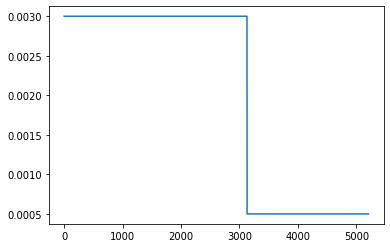

In [14]:
start = time.time()
# Create the model:
model = MiniCNN(num_channels=3)
# Create the optimizer:
optimizer = CONFIG.optimizer_factory(model)
# Create the learning rate scheduler:
learning_rate_scheduler = CustomLRScheduler(optimizer, **CONFIG.lrs_kwargs)
# Train the model:
epoch_loses, all_loses,all_accuracies = train(
                                        model,
                                        train_loader,
                                        test_loader,
                                        num_epochs= 15,#CONFIG.num_epochs,
                                        optimizer=optimizer,
                                        criterion=criterion,
                                        learning_rate_scheduler=learning_rate_scheduler,
                                    )
print( (time.time() - start)/60 , 'minutes')

In [140]:
el_lr, al_lr, acc_lr = epoch_loses.copy(), all_loses.copy(),all_accuracies.copy()

Text(0.5, 1.0, 'Accuracies')

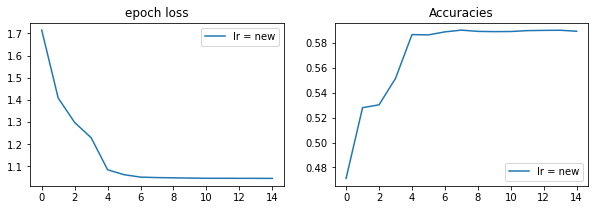

In [131]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(el_lr, label ='lr = new' )

# plt.plot(el_lr_003_0003, label ='lr = 0.003(4)-0.0003' )
# plt.plot(el_lr_003_0005_5, label ='lr = 0.003(5)-0.0005' )
# plt.plot(el_lr_003_0005, label ='lr = 0.003(4)-0.0005' )
# plt.plot(el_lr_003_0005_4, label ='lr = 0.003(4*)-0.0005' )
# plt.plot(el_lr_003_0001_4, label ='lr = 0.003(4*)-0.0001' )
# plt.plot(el_lr_003_0005_3, label ='lr = 0.003(3)-0.0005' )


# plt.plot(el_lr_003_0005_0001, label ='lr = 0.003(4)-0.0005(6)-0.0001' )
# plt.plot(el_lr_003_0005_00005, label ='lr = 0.003(4)-0.0005(6)-0.00005' )
# plt.plot(el_lr_003_0005_00005_10, label ='lr = 0.003(4)-0.0005(10)-0.00005' )


plt.legend()
plt.title('epoch loss')
plt.subplot(1,2,2)
plt.plot(acc_lr, label ='lr = new' )

# plt.plot(acc_lr_003_0003, label ='lr = 0.003(4)-0.0003' )
# plt.plot(acc_lr_003_0005_5, label ='lr = 0.003(5)-0.0005' )
# plt.plot(acc_lr_003_0005, label ='lr = 0.003(4)-0.0005' )
# plt.plot(acc_lr_003_0005_4, label ='lr = 0.003(4*)-0.0005' )
# plt.plot(acc_lr_003_0001_4, label ='lr = 0.003(4*)-0.0001' )

# plt.plot(acc_lr_003_0005_3, label ='lr = 0.003(3)-0.0005' )

# plt.plot(acc_lr_003_0005_0001, label ='lr = 0.003(4)-0.0005(6)-0.0001' )
# plt.plot(acc_lr_003_0005_00005, label ='lr = 0.003(4)-0.0005(6)-0.00005' )
# plt.plot(acc_lr_003_0005_00005_10, label ='lr = 0.003(4)-0.0005(10)-0.00005' )



plt.legend()
plt.title('Accuracies')

Text(0.5, 1.0, 'Accuracies')

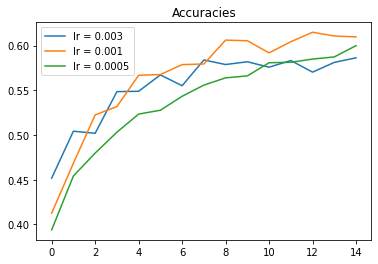

In [ ]:
# Defualt 0.001: 0.42, 0.48, 0.51